# JetBot Behavior Cloning - PC Training Notebook

This notebook runs on your **PC** for training the steering model.

## Workflow
1. **Config** - Set all parameters
2. **Dataset** - Load and analyze data
3. **Model** - Define ResNet18 architecture
4. **Training** - Train with early stopping
5. **Evaluation** - Visualize results with telemetry

## Requirements
- PyTorch with CUDA
- torchvision
- opencv-python
- matplotlib
- scikit-learn

In [15]:
# =============================================================================
# CELL 1: CONFIGURATION
# =============================================================================
# All parameters defined here - shared across all cells
# Modify these values as needed

import torch
import os
import glob
import random

# -----------------------------------------------------------------------------
# PATHS
# -----------------------------------------------------------------------------
DATASET_DIR = 'dataset_v1'           # Main training data
DAGGER_DIR = 'dataset_dagger'        # DAgger corrections (optional)
MODEL_SAVE_PATH = 'steering_model_v1.pth'

# -----------------------------------------------------------------------------
# PREPROCESSING (must match JetBot notebook)
# -----------------------------------------------------------------------------
CROP_TOP = 0.20
CROP_BOTTOM = 0.00
CROP_LEFT = 0.08
CROP_RIGHT = 0.12
INPUT_SIZE = (224, 224)

# ImageNet normalization (required for pretrained ResNet)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# -----------------------------------------------------------------------------
# TRAINING
# -----------------------------------------------------------------------------
BATCH_SIZE = 8              # Reduce if GPU out of memory
LEARNING_RATE = 1e-4
EPOCHS = 50
PATIENCE = 7                # Early stopping patience
VAL_SPLIT = 0.2             # 20% validation

# -----------------------------------------------------------------------------
# AUGMENTATION
# -----------------------------------------------------------------------------
AUG_BRIGHTNESS = 0.3
AUG_CONTRAST = 0.3
AUG_SATURATION = 0.3
AUG_HUE = 0.05

# -----------------------------------------------------------------------------
# DEVICE
# -----------------------------------------------------------------------------
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Configuration loaded.")
print(f"  Device: {DEVICE}")
print(f"  Dataset: {DATASET_DIR}")
print(f"  Model save path: {MODEL_SAVE_PATH}")

Configuration loaded.
  Device: cuda
  Dataset: dataset_v1
  Model save path: steering_model_v1.pth


In [13]:
# =============================================================================
# CELL 2: DATASET
# =============================================================================

import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms

# -----------------------------------------------------------------------------
# Dataset Class
# -----------------------------------------------------------------------------
class SteeringDataset(Dataset):
    """Dataset for loading steering images. Filename format: {timestamp}_{steering}.jpg"""
    
    def __init__(self, file_list, transform=None):
        self.files = file_list
        self.transform = transform
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        filepath = self.files[idx]
        
        # Load image (BGR) and convert to RGB
        img_bgr = cv2.imread(filepath)
        if img_bgr is None:
            return torch.zeros(3, INPUT_SIZE[0], INPUT_SIZE[1]), torch.tensor([0.0])
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            img_tensor = self.transform(img_rgb)
        else:
            img_tensor = torch.from_numpy(img_rgb.transpose(2, 0, 1)).float() / 255.0
        
        # Extract steering from filename
        filename = os.path.basename(filepath)
        try:
            steering = float(filename.split('_')[1].replace('.jpg', ''))
        except (IndexError, ValueError):
            steering = 0.0
        
        return img_tensor, torch.tensor([steering], dtype=torch.float32)


# -----------------------------------------------------------------------------
# Transforms
# -----------------------------------------------------------------------------
def get_training_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(
            brightness=AUG_BRIGHTNESS,
            contrast=AUG_CONTRAST,
            saturation=AUG_SATURATION,
            hue=AUG_HUE
        ),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])


def get_validation_transforms():
    return transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
    ])


# -----------------------------------------------------------------------------
# Load Dataset Function
# -----------------------------------------------------------------------------
def load_dataset(dataset_dirs, val_split=VAL_SPLIT):
    """
    Load dataset from one or more directories.
    
    Args:
        dataset_dirs: String or list of strings with dataset paths
        val_split: Validation split ratio
    """
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    # Collect all files
    all_files = []
    for d in dataset_dirs:
        files = glob.glob(os.path.join(d, "*.jpg"))
        all_files.extend(files)
        print(f"  {d}: {len(files)} images")
    
    all_files = sorted(all_files)
    print(f"Total: {len(all_files)} images")
    
    if len(all_files) == 0:
        raise ValueError("No images found!")
    
    # Split
    train_files, val_files = train_test_split(
        all_files, test_size=val_split, shuffle=True, random_state=42
    )
    print(f"Train: {len(train_files)} | Val: {len(val_files)}")
    
    # Create datasets and loaders
    train_dataset = SteeringDataset(train_files, transform=get_training_transforms())
    val_dataset = SteeringDataset(val_files, transform=get_validation_transforms())
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                              num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=4, pin_memory=True)
    
    return train_dataset, val_dataset, train_loader, val_loader


# -----------------------------------------------------------------------------
# Analysis Functions
# -----------------------------------------------------------------------------
def analyze_dataset(dataset_dirs):
    """Analyze steering distribution in dataset."""
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    all_files = []
    for d in dataset_dirs:
        all_files.extend(glob.glob(os.path.join(d, "*.jpg")))
    
    # Extract steering values
    steering_values = []
    for f in all_files:
        try:
            steering = float(os.path.basename(f).split('_')[1].replace('.jpg', ''))
            steering_values.append(steering)
        except:
            pass
    
    steering_values = np.array(steering_values)
    
    # Statistics
    print("="*50)
    print("DATASET ANALYSIS")
    print("="*50)
    print(f"Total images: {len(all_files)}")
    print(f"Steering range: [{steering_values.min():.3f}, {steering_values.max():.3f}]")
    print(f"Steering mean: {steering_values.mean():.3f}")
    print(f"Steering std: {steering_values.std():.3f}")
    
    # Balance
    left = np.sum(steering_values < -0.1)
    center = np.sum(np.abs(steering_values) <= 0.1)
    right = np.sum(steering_values > 0.1)
    print(f"\nBalance: Left {left} ({100*left/len(steering_values):.1f}%) | "
          f"Center {center} ({100*center/len(steering_values):.1f}%) | "
          f"Right {right} ({100*right/len(steering_values):.1f}%)")
    print("="*50)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].hist(steering_values, bins=50, edgecolor='black', alpha=0.7)
    axes[0].axvline(x=0, color='r', linestyle='--')
    axes[0].set_xlabel('Steering')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Steering Distribution')
    
    axes[1].plot(steering_values, alpha=0.7, linewidth=0.5)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('Steering')
    axes[1].set_title('Steering Over Time')
    
    plt.tight_layout()
    plt.show()
    
    return steering_values


def visualize_samples(dataset_dirs, num_samples=8):
    """Display random samples from dataset."""
    if isinstance(dataset_dirs, str):
        dataset_dirs = [dataset_dirs]
    
    all_files = []
    for d in dataset_dirs:
        all_files.extend(glob.glob(os.path.join(d, "*.jpg")))
    
    indices = np.random.choice(len(all_files), min(num_samples, len(all_files)), replace=False)
    
    cols = 4
    rows = (len(indices) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        img = cv2.imread(all_files[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        steering = float(os.path.basename(all_files[idx]).split('_')[1].replace('.jpg', ''))
        
        axes[i].imshow(img_rgb)
        axes[i].set_title(f'Steer: {steering:.2f}')
        axes[i].axis('off')
    
    for i in range(len(indices), len(axes)):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()




def visualize_augmentation(img_path, num_samples=5):
    """
    Show original image and several augmented versions.
    Useful for verifying augmentation is working correctly.
    
    Args:
        img_path: Path to a saved training image
        num_samples: Number of augmented versions to show
    """
    import matplotlib.pyplot as plt
    
    # Load image (saved as BGR during collection)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    train_transform = get_training_transforms()
    
    fig, axes = plt.subplots(1, num_samples + 1, figsize=(3 * (num_samples + 1), 3))
    
    # Original
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Augmented versions
    for i in range(num_samples):
        # Apply transform (includes normalization, so we need to denormalize for display)
        augmented = train_transform(img_rgb)
        
        # Denormalize for visualization
        denorm = augmented.clone()
        for c in range(3):
            denorm[c] = denorm[c] * IMAGENET_STD[c] + IMAGENET_MEAN[c]
        denorm = torch.clamp(denorm, 0, 1)
        
        # CHW -> HWC for display
        display_img = denorm.permute(1, 2, 0).numpy()
        
        axes[i + 1].imshow(display_img)
        axes[i + 1].set_title(f'Augmented {i + 1}')
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()


print("Dataset functions loaded.")

Dataset functions loaded.


In [3]:
# =============================================================================
# CELL 3: MODEL
# =============================================================================

import torch.nn as nn
import torchvision.models as models

def get_model(pretrained=True):
    """Create ResNet18 model for steering prediction."""
    if pretrained:
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        print("Loaded ResNet18 with ImageNet pretrained weights")
    else:
        model = models.resnet18(weights=None)
        print("Loaded ResNet18 without pretrained weights")
    
    # Replace final layer: 1000 classes -> 1 steering value
    model.fc = nn.Linear(model.fc.in_features, 1)
    
    return model


def print_model_summary(model):
    """Print model parameter count and test forward pass."""
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Parameters: {total:,} total, {trainable:,} trainable")
    
    # Test forward pass
    model.eval()
    device = next(model.parameters()).device
    dummy = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        out = model(dummy)
    print(f"Input: {dummy.shape} -> Output: {out.shape}")


print("Model functions loaded.")

Model functions loaded.


In [4]:
# =============================================================================
# CELL 4: TRAINING
# =============================================================================

import torch.optim as optim
import time
from copy import deepcopy

def train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LEARNING_RATE, 
                patience=PATIENCE, save_path=MODEL_SAVE_PATH):
    """Train the model with early stopping."""
    
    model = model.to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    print("="*60)
    print(f"TRAINING | Device: {DEVICE} | Epochs: {epochs} | LR: {lr}")
    print("="*60)
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            loss = criterion(model(images), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                val_loss += criterion(model(images), labels).item()
        
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        current_lr = optimizer.param_groups[0]['lr']
        
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)
        history['lr'].append(current_lr)
        
        # Check improvement
        improved = ""
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            best_model_state = deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
            improved = "✓ BEST"
        else:
            patience_counter += 1
        
        print(f"Epoch {epoch+1:3d}/{epochs} | Train: {avg_train:.6f} | Val: {avg_val:.6f} | LR: {current_lr:.2e} {improved}")
        
        scheduler.step(avg_val)
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    print("="*60)
    print(f"Training complete in {(time.time()-start_time)/60:.1f} min | Best val loss: {best_val_loss:.6f}")
    print(f"Model saved to: {save_path}")
    print("="*60)
    
    model.load_state_dict(best_model_state)
    return model, history


def plot_history(history):
    """Plot training curves."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val')
    best_epoch = history['val_loss'].index(min(history['val_loss'])) + 1
    axes[0].axvline(x=best_epoch, color='g', linestyle='--', label=f'Best: {best_epoch}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(epochs, history['lr'], 'g-')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Learning Rate')
    axes[1].set_title('Learning Rate Schedule')
    axes[1].set_yscale('log')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()


print("Training functions loaded.")

Training functions loaded.


In [5]:
# =============================================================================
# CELL 5: EVALUATION & TELEMETRY
# =============================================================================

def evaluate_model(model, val_loader):
    """Evaluate model and return predictions."""
    model.eval()
    model.to(DEVICE)
    
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            preds = model(images)
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.numpy().flatten())
    
    preds = np.array(all_preds)
    labels = np.array(all_labels)
    
    mse = np.mean((preds - labels) ** 2)
    mae = np.mean(np.abs(preds - labels))
    
    print("="*40)
    print("EVALUATION")
    print("="*40)
    print(f"MSE:  {mse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"RMSE: {np.sqrt(mse):.6f}")
    print("="*40)
    
    return preds, labels


def plot_predictions(preds, labels):
    """Plot prediction scatter and overview."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Scatter
    axes[0].scatter(labels, preds, alpha=0.3, s=5)
    axes[0].plot([-1, 1], [-1, 1], 'r--', label='Perfect')
    axes[0].set_xlabel('Actual')
    axes[0].set_ylabel('Predicted')
    axes[0].set_title('Predicted vs Actual')
    axes[0].set_xlim(-1.1, 1.1)
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].legend()
    axes[0].grid(True)
    
    # Error distribution
    errors = preds - labels
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='r', linestyle='--')
    axes[1].set_xlabel('Prediction Error')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'Error Distribution (mean={errors.mean():.3f}, std={errors.std():.3f})')
    
    plt.tight_layout()
    plt.show()


def plot_telemetry(preds, labels, start=0, length=200):
    """
    Plot detailed telemetry view of predictions vs ground truth.
    Zoomed in to see details clearly.
    
    Args:
        preds: Model predictions
        labels: Ground truth
        start: Starting frame index
        length: Number of frames to show
    """
    end = min(start + length, len(labels))
    x = np.arange(start, end)
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    
    # Steering comparison
    axes[0].plot(x, labels[start:end], 'b-', linewidth=1.5, label='Ground Truth', alpha=0.8)
    axes[0].plot(x, preds[start:end], 'r--', linewidth=1.5, label='Predicted', alpha=0.8)
    axes[0].fill_between(x, labels[start:end], preds[start:end], alpha=0.2, color='gray')
    axes[0].set_ylabel('Steering')
    axes[0].set_ylim(-1.1, 1.1)
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    axes[0].set_title(f'Telemetry: Frames {start} - {end}')
    
    # Error
    errors = preds[start:end] - labels[start:end]
    axes[1].bar(x, errors, width=1.0, color=['red' if e > 0 else 'blue' for e in errors], alpha=0.7)
    axes[1].axhline(y=0, color='black', linewidth=0.5)
    axes[1].set_ylabel('Error')
    axes[1].set_xlabel('Frame')
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Stats for this segment
    segment_mae = np.mean(np.abs(errors))
    segment_max = np.max(np.abs(errors))
    print(f"Segment stats: MAE={segment_mae:.4f}, Max error={segment_max:.4f}")


def plot_saliency(model, image_path):
    """
    Show saliency map - what pixels influence the steering prediction.
    
    Args:
        model: Trained model
        image_path: Path to image file
    """
    model.eval()
    model.to(DEVICE)
    
    # Load and preprocess image
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    
    transform = get_validation_transforms()
    img_tensor = transform(img_rgb).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad = True
    
    # Forward pass
    output = model(img_tensor)
    
    # Backward pass
    model.zero_grad()
    output.backward()
    
    # Get saliency
    saliency = img_tensor.grad.data.abs().squeeze().cpu()
    saliency = saliency.max(dim=0)[0]  # Max across channels
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-8)
    
    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(img_rgb)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(saliency.numpy(), cmap='hot')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')
    
    axes[2].imshow(img_rgb)
    axes[2].imshow(saliency.numpy(), cmap='hot', alpha=0.5)
    axes[2].set_title(f'Overlay (pred: {output.item():.2f})')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()


print("Evaluation functions loaded.")

Evaluation functions loaded.


---
## Run Training

Execute the cells below to train your model.

DATASET ANALYSIS
Total images: 8314
Steering range: [-1.000, 1.000]
Steering mean: 0.163
Steering std: 0.535

Balance: Left 1216 (14.6%) | Center 3923 (47.2%) | Right 3175 (38.2%)


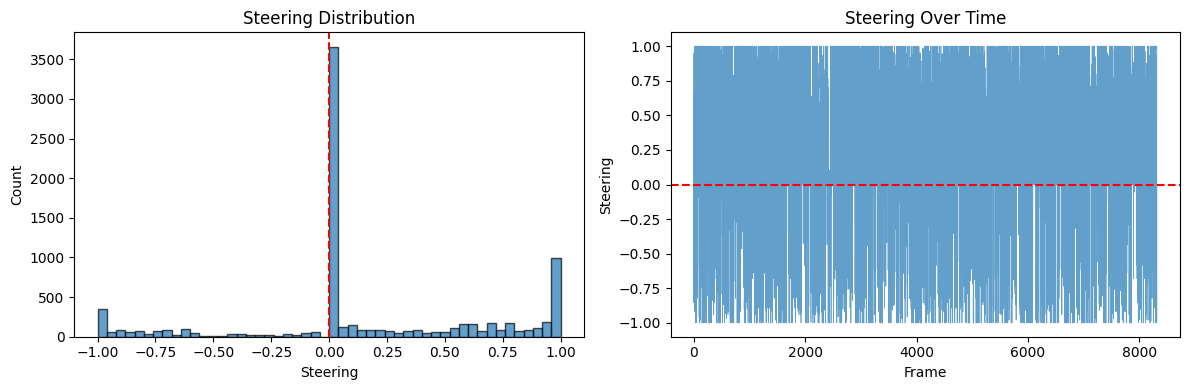

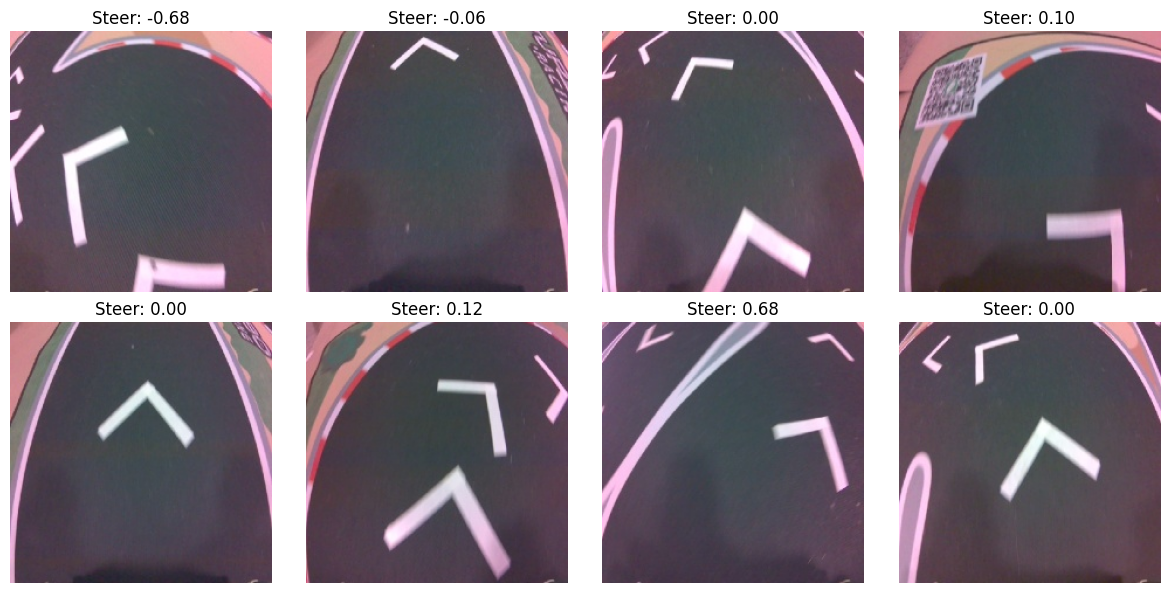

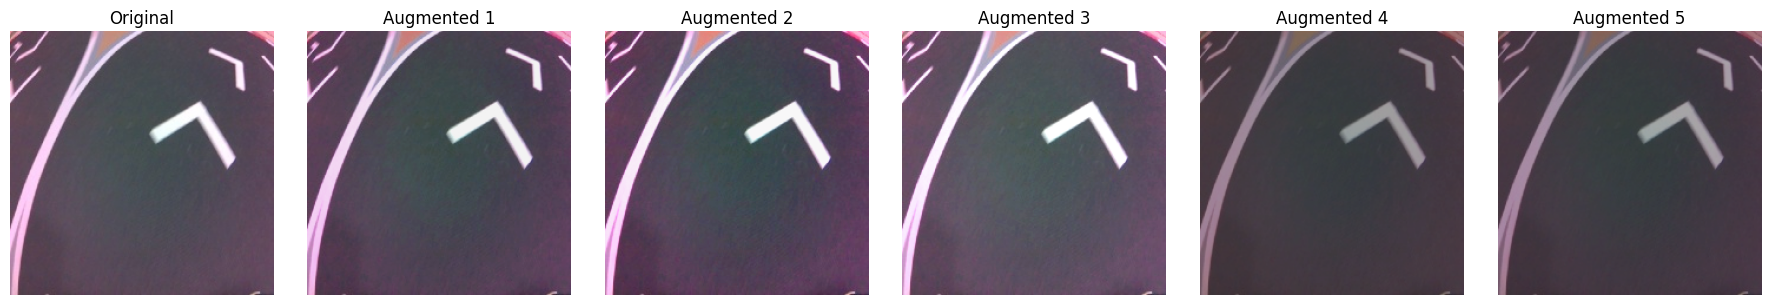

In [16]:
# Analyze dataset first
_ = analyze_dataset(DATASET_DIR)
visualize_samples(DATASET_DIR)
images = glob.glob(os.path.join(DATASET_DIR, "*.jpg"))
visualize_augmentation(random.choice(images))

In [7]:
# Clear GPU memory and load data
import gc
gc.collect()
torch.cuda.empty_cache()

# Load dataset (use list for multiple dirs: [DATASET_DIR, DAGGER_DIR])
train_dataset, val_dataset, train_loader, val_loader = load_dataset(DATASET_DIR)

  dataset_v1: 8314 images
Total: 8314 images
Train: 6651 | Val: 1663


In [8]:
# Create and train model
model = get_model(pretrained=True)
model, history = train_model(model, train_loader, val_loader)

Loaded ResNet18 with ImageNet pretrained weights
TRAINING | Device: cuda | Epochs: 50 | LR: 0.0001
Epoch   1/50 | Train: 0.095437 | Val: 0.040732 | LR: 1.00e-04 ✓ BEST
Epoch   2/50 | Train: 0.043255 | Val: 0.040693 | LR: 1.00e-04 ✓ BEST
Epoch   3/50 | Train: 0.035499 | Val: 0.036192 | LR: 1.00e-04 ✓ BEST
Epoch   4/50 | Train: 0.030667 | Val: 0.047929 | LR: 1.00e-04 
Epoch   5/50 | Train: 0.027803 | Val: 0.034352 | LR: 1.00e-04 ✓ BEST
Epoch   6/50 | Train: 0.024884 | Val: 0.035678 | LR: 1.00e-04 
Epoch   7/50 | Train: 0.021163 | Val: 0.036854 | LR: 1.00e-04 
Epoch   8/50 | Train: 0.017369 | Val: 0.037457 | LR: 1.00e-04 
Epoch   9/50 | Train: 0.014649 | Val: 0.034694 | LR: 1.00e-04 
Epoch  10/50 | Train: 0.007953 | Val: 0.028460 | LR: 5.00e-05 ✓ BEST
Epoch  11/50 | Train: 0.005375 | Val: 0.029242 | LR: 5.00e-05 
Epoch  12/50 | Train: 0.004282 | Val: 0.028803 | LR: 5.00e-05 
Epoch  13/50 | Train: 0.004147 | Val: 0.030433 | LR: 5.00e-05 
Epoch  14/50 | Train: 0.004461 | Val: 0.030019 | LR:

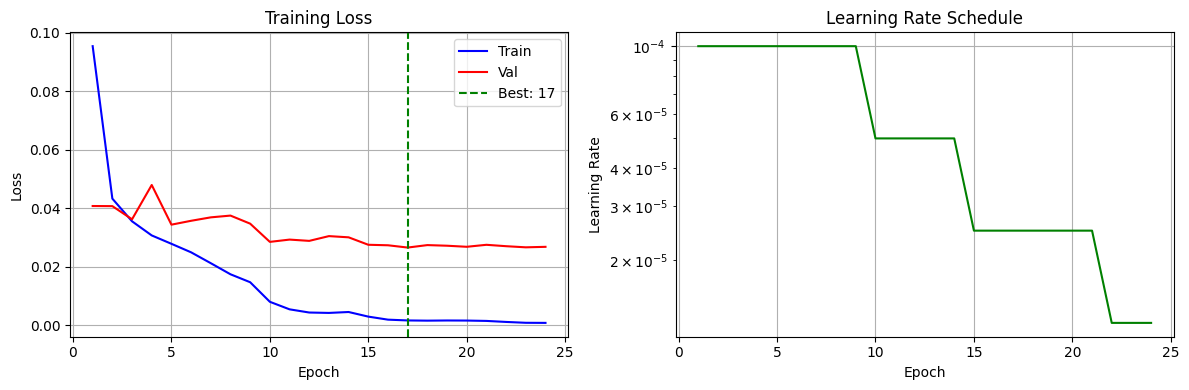

In [9]:
# Visualize training
plot_history(history)

EVALUATION
MSE:  0.026497
MAE:  0.091687
RMSE: 0.162779


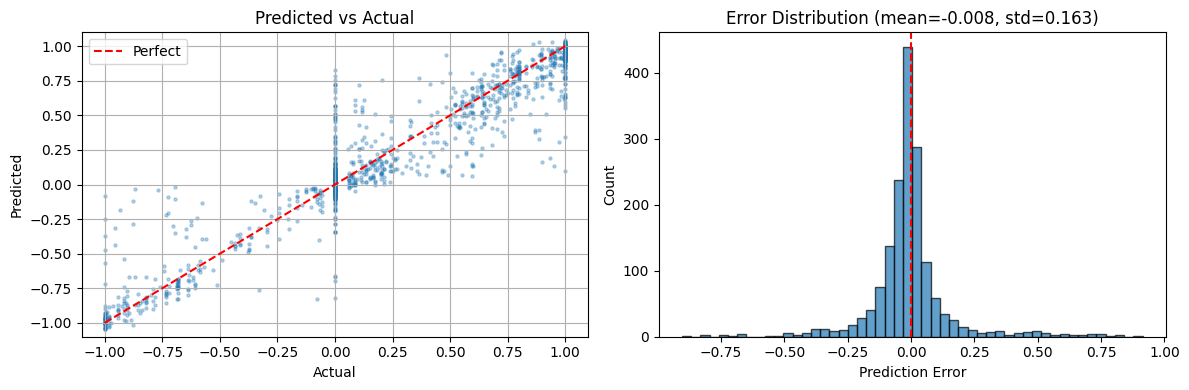

In [10]:
# Evaluate
preds, labels = evaluate_model(model, val_loader)
plot_predictions(preds, labels)

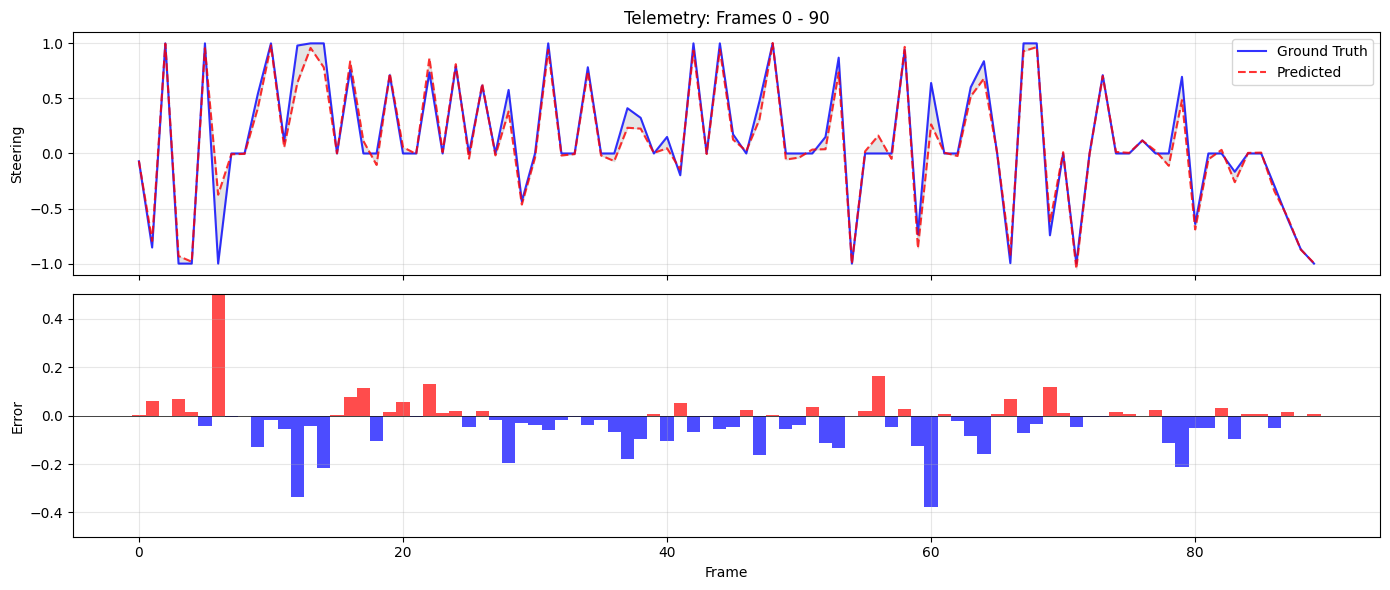

Segment stats: MAE=0.0664, Max error=0.6256


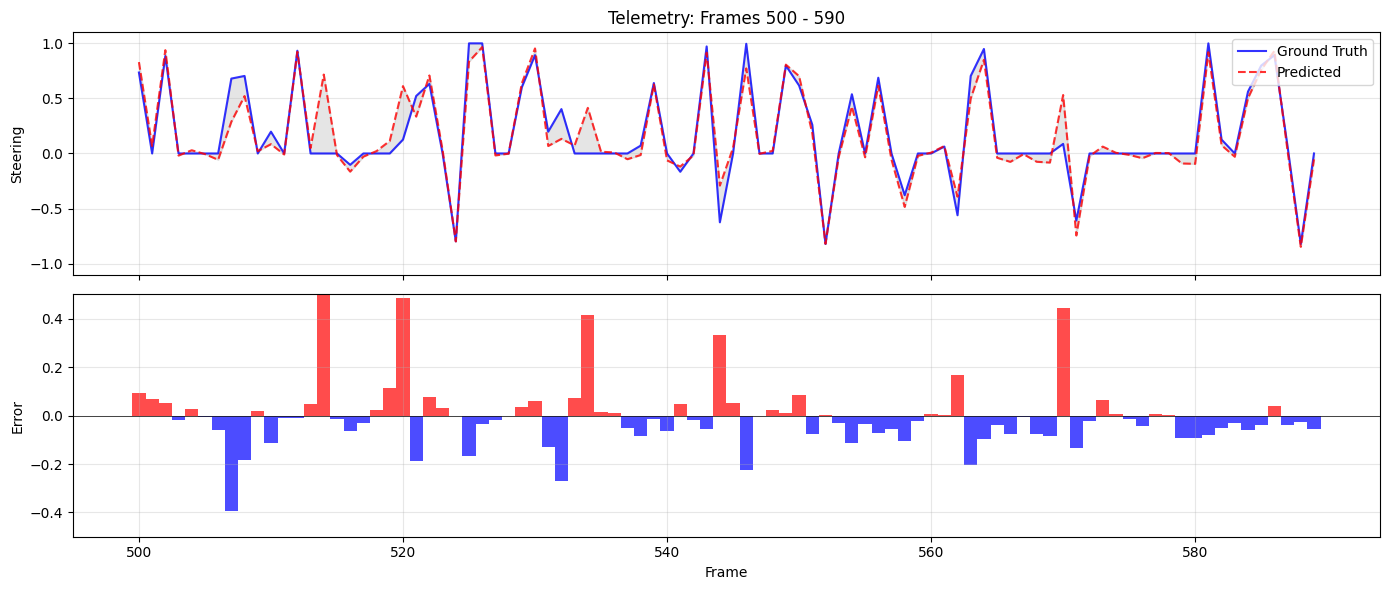

Segment stats: MAE=0.0861, Max error=0.7167


In [23]:
# Telemetry view (zoomed in)
plot_telemetry(preds, labels, start=0, length=90)
plot_telemetry(preds, labels, start=500, length=90)

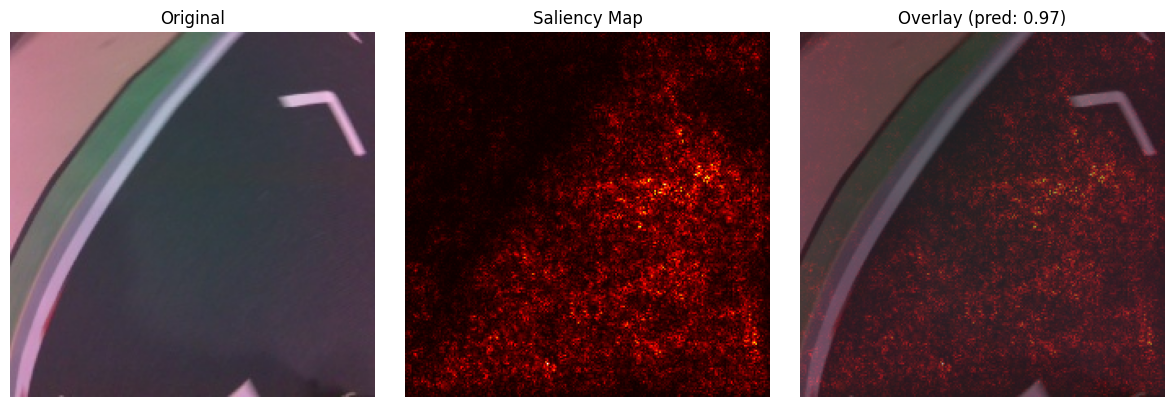

In [21]:
# Saliency map (pick a random image)
import random
sample_images = glob.glob(os.path.join(DATASET_DIR, "*.jpg"))
plot_saliency(model, random.choice(sample_images))

---
## Retrain with DAgger Data

After collecting corrections on JetBot, combine datasets and retrain:

  dataset_dagger: 8497 images
Total: 8497 images
Train: 6797 | Val: 1700
Loaded ResNet18 with ImageNet pretrained weights
TRAINING | Device: cuda | Epochs: 50 | LR: 0.0001
Epoch   1/50 | Train: 0.100503 | Val: 0.055696 | LR: 1.00e-04 ✓ BEST
Epoch   2/50 | Train: 0.046815 | Val: 0.045427 | LR: 1.00e-04 ✓ BEST
Epoch   3/50 | Train: 0.039125 | Val: 0.039065 | LR: 1.00e-04 ✓ BEST
Epoch   4/50 | Train: 0.033187 | Val: 0.042585 | LR: 1.00e-04 
Epoch   5/50 | Train: 0.028907 | Val: 0.042042 | LR: 1.00e-04 
Epoch   6/50 | Train: 0.027123 | Val: 0.042247 | LR: 1.00e-04 
Epoch   7/50 | Train: 0.023115 | Val: 0.032358 | LR: 1.00e-04 ✓ BEST
Epoch   8/50 | Train: 0.019747 | Val: 0.036651 | LR: 1.00e-04 
Epoch   9/50 | Train: 0.015974 | Val: 0.038395 | LR: 1.00e-04 
Epoch  10/50 | Train: 0.014117 | Val: 0.038799 | LR: 1.00e-04 
Epoch  11/50 | Train: 0.012056 | Val: 0.036099 | LR: 1.00e-04 
Epoch  12/50 | Train: 0.006011 | Val: 0.027795 | LR: 5.00e-05 ✓ BEST
Epoch  13/50 | Train: 0.003934 | Val: 0.02

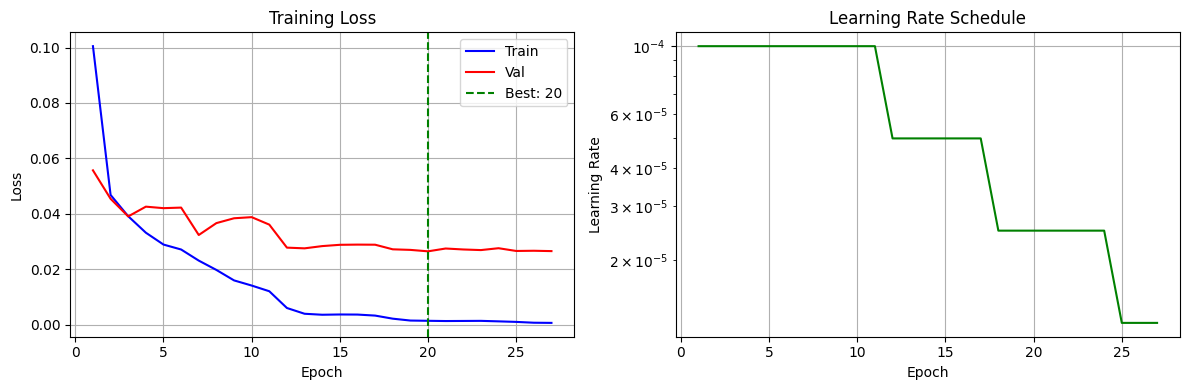

In [26]:
# Retrain with combined data (original + DAgger)


gc.collect()
torch.cuda.empty_cache()

train_dataset, val_dataset, train_loader, val_loader = load_dataset([ DAGGER_DIR])
model = get_model(pretrained=True)
model, history = train_model(model, train_loader, val_loader, save_path='steering_model_dagger.pth')
plot_history(history)

EVALUATION
MSE:  0.026525
MAE:  0.089192
RMSE: 0.162866


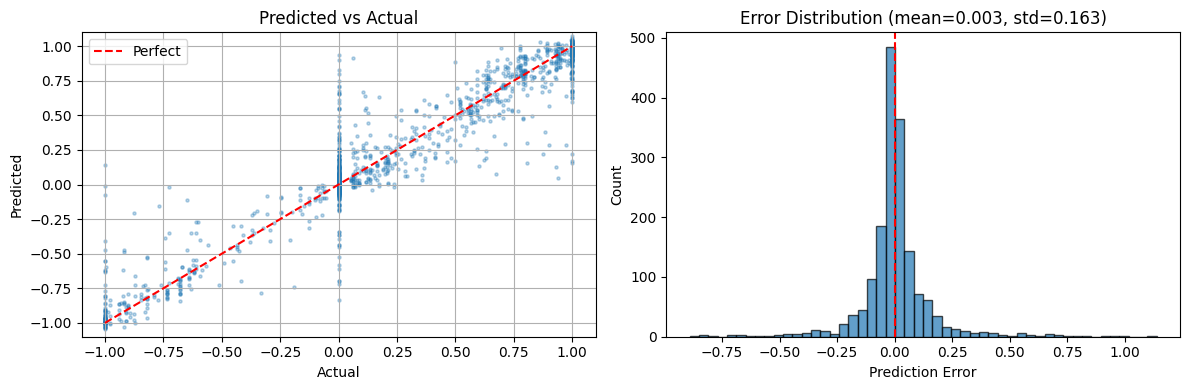

In [27]:
# Evaluate
preds, labels = evaluate_model(model, val_loader)
plot_predictions(preds, labels)

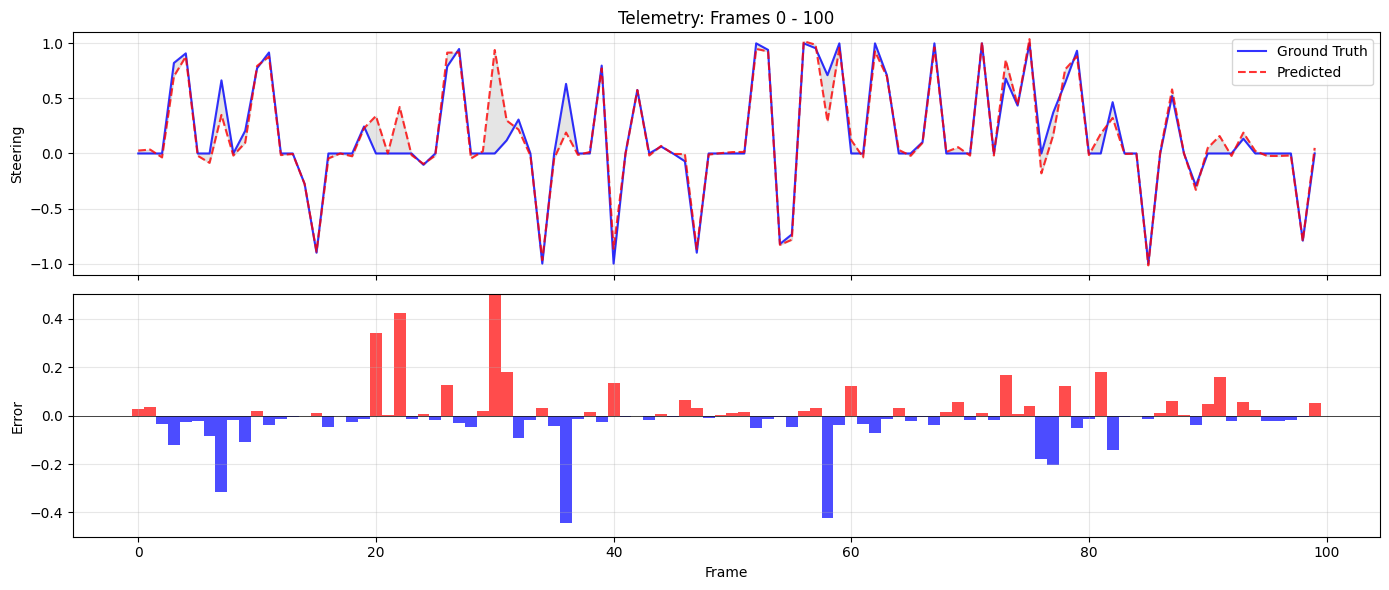

Segment stats: MAE=0.0686, Max error=0.9395


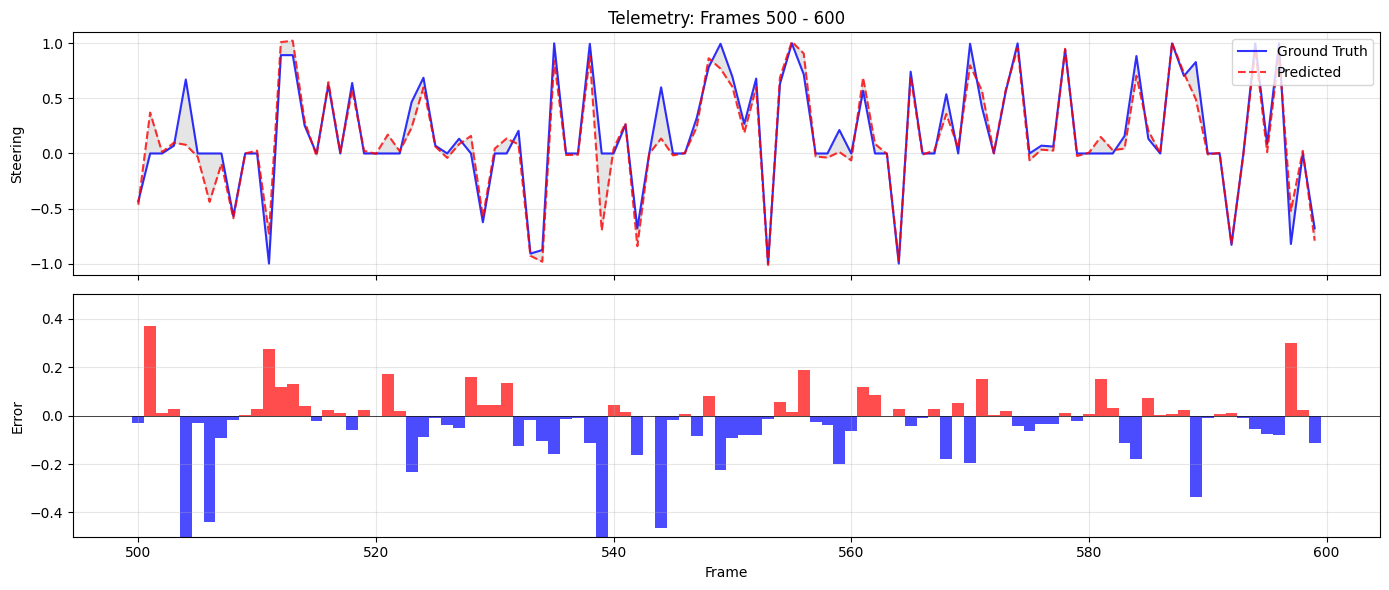

Segment stats: MAE=0.0927, Max error=0.6992


In [28]:
# Telemetry view (zoomed in)
plot_telemetry(preds, labels, start=0, length=100)
plot_telemetry(preds, labels, start=500, length=100)